In [1]:
import loader as ld
import plots as pl
import analysis as an
import patterns as pt
import pandas as pd
import numpy as np

In [4]:
tickers = 'META'

In [5]:
stock_data = ld.load_data(tickers)
stock_data = ld.check_clean_data(stock_data, verbose=True)

In [6]:
df = stock_data[tickers]['historical_data']
stock_data[tickers]['splits']

Series([], Name: Stock Splits, dtype: float64)

In [7]:
pl.plot_chart(df, ticker=tickers)

In [8]:
# add percentage and log returns
df = an.add_pct_log_returns(df)
# create another df with additional inticators
support_df = an.calculate_ATR(df)

In [9]:
# available patterns
print(list(pt.patterns.keys()))

['Morning Star', 'Evening Star', 'Three White Soldiers', 'Three Black Crows', 'Bullish Engulfing', 'Bearish Engulfing', 'Bullish Piercing Line', 'Bearish Piercing Line', 'Bullish Harami', 'Bearish Harami', 'Bullish Marubozu', 'Bearish Marubozu']


In [11]:
pattern_name = "Bullish Engulfing"  # replace with the desired pattern name

# check if the pattern exists in the patterns dictionary
if pattern_name in pt.patterns:
    pattern_function = pt.patterns[pattern_name]['function']
    pattern_num_candles = pt.patterns[pattern_name]['candles']
    # use the function to obtain the mask of the pattern dates
    mask = pattern_function(pd.concat([df, support_df], axis=1))
    # filter the mask to ensure consistency in the future analysis
    #mask = pt.filter_mask(mask, step=10)
    dim_pattern_sample = mask.sum()
    print(mask.sum())
else:
    print(f"The pattern '{pattern_name}' does not exist.")

53


In [12]:
pl.plot_close_with_patterns(df, tickers, mask, pattern_name)

In [27]:
pl.plot_patterns(df, mask, num_candles=pattern_num_candles, ticker=tickers, pattern_name=pattern_name)

# PATTERN VS BASE CASE

### PATTERN CASE

Assumption: for now we will analyze the real samples vs 1000 random base case samples

Pattern returns - one sample of around 100 observations

In [14]:
pattern_returns = an.calculate_cumReturns_periods(df, mask, max_ahead=15)
pattern_log_returns = an.calculate_log_cumReturns_periods(df, mask, max_ahead=15)
# round the returns to 3 decimal places and multiply by 100
pattern_rounded_returns = {k: [round(100*r,3) for r in v] for k, v in pattern_returns.items()}

In [15]:
pattern_avg_returns = an.calculate_average_return(pattern_rounded_returns)
pattern_median_returns = an.calculate_median_return(pattern_rounded_returns)
pattern_win_rate = an.calculate_win_rate(pattern_rounded_returns)

In [16]:
pattern_log_avg_returns = an.calculate_average_return_from_log(pattern_log_returns)
pattern_log_median_returns = an.calculate_median_return_from_log(pattern_log_returns)
pattern_win_rate_log = an.calculate_win_rate_from_log(pattern_log_returns)
pattern_std_returns_log = an.calculate_std_return_from_log(pattern_log_returns)

### BASE CASE

Random base case returns - 1000 samples

In [17]:
baseline_returns = an.generate_random_returns(df, input_mask = mask, dim_sample=dim_pattern_sample, n_iterations=1000, 
                                            is_log=True, verbose=False)

In [18]:
baseline_distributions = an.calculate_metrics(baseline_returns)
nonParametric_conf_intervals = an.calculate_nonParametric_confidence_intervals(baseline_distributions, low_perc=2.5, high_perc=97.5, is_log_ret=True)
parametric_conf_intervals = an.calculate_parametric_confidence_intervals(baseline_distributions, confidence_level=0.95, is_log_ret=True)

### Plot distributions of metrics (optional)

In [19]:
print(baseline_distributions.keys())

dict_keys(['win_rate', 'average_return', 'median_return', 'std_return'])


In [22]:
#pl.plot_metric_distributions(metrics=baseline_distributions, metric_name='average_return')

In [23]:
#pl.qq_plot(metrics=baseline_distributions, metric_name='average_return')

In [24]:
pattern_metrics = {
    'average_return': pattern_log_avg_returns,
    'median_return': pattern_log_median_returns,
    'win_rate': pattern_win_rate_log
}
base_metrics = nonParametric_conf_intervals

pl.plot_compared_metrics(pattern_metrics, base_metrics, pattern_name, show_interval='median_return')

In [25]:
empirical_pvalues = an.calculate_empirical_pvalues(pattern_metrics=pattern_metrics, base_distributions=baseline_distributions)
# Assuming your original confidence intervals are stored in variables called 'parametric_confidence_intervals' and 'nonParametric_confidence_intervals'
parametric_conf_int, basecase_estimates = an.transform_confidence_intervals(parametric_conf_intervals)
non_parametric_conf_int, _ = an.transform_confidence_intervals(nonParametric_conf_intervals)
table = an.create_significance_table(pattern_metrics=pattern_metrics, basecase_estimates=basecase_estimates,
                                    empirical_pvalues=empirical_pvalues, parametric_conf_int=parametric_conf_int,
                                    non_parametric_conf_int=non_parametric_conf_int)

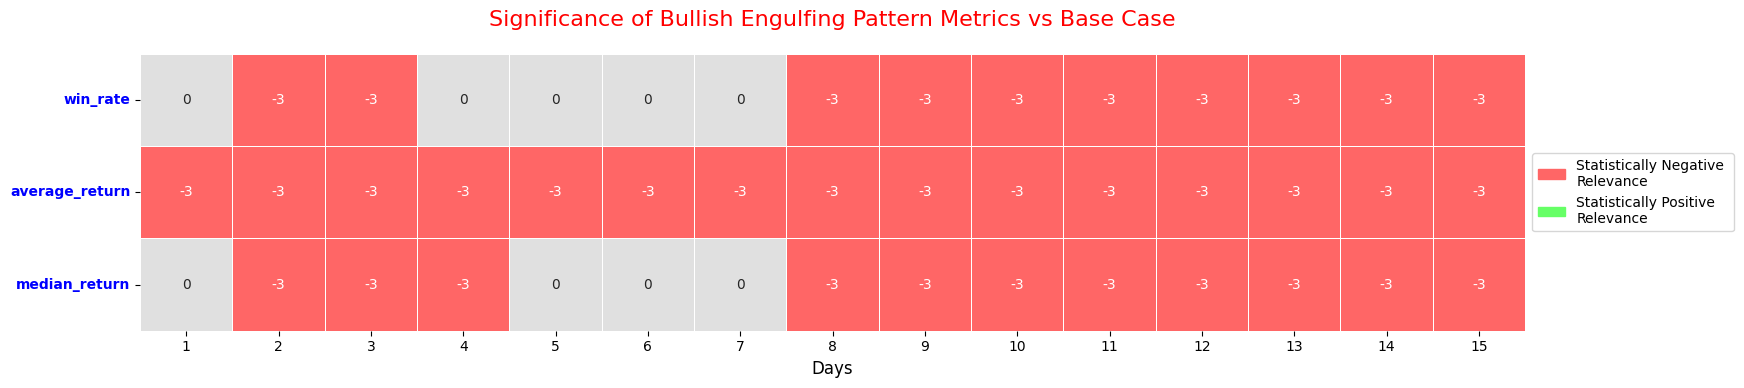

In [26]:
pl.plot_significance_heatmap(table, pattern_name)